Deep Learning
=============



The goal of is to train a Word2Vec skip-gram model over pro-ISIS twitter data and visualize the learned embeddings using t-SNE

reference: https://www.tensorflow.org/tutorials/word2vec

NLP tutorial using word2vec if you don't want to go the deep learning route: https://www.kaggle.com/c/word2vec-nlp-tutorial

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import matplotlib.pyplot as plt
#from __future__ import print_function
import collections
import math
import numpy as np
import pandas as pd
import os
import random
from itertools import chain
import tensorflow as tf
#import zipfile
from matplotlib import pylab
from six.moves import range
#from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Read in the data

In [2]:
df=pd.read_csv('tweets.csv')

## Remove stopwords using NLTK
### (Natural Language Toolkit)
http://www.nltk.org/

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
 
punctuation = list(string.punctuation)
#declare list of words to remove
stop = stopwords.words('english') + punctuation + ['rt', 'via', 'english', 'translation:'] 

In [4]:
df['tweets'] = df['tweets'].str.lower().str.split()
df['tweets']= df['tweets'].apply(lambda x: [item for item in x if item not in stop])

In [5]:
#print one tweet
df['tweets'][48]

['@abuyaqub6:',
 '@alwalawalbara12:',
 'may',
 'allah',
 'punish',
 'every',
 'shiite',
 'https://t.co/y1wwfrjdtp/s/aqau']

In [6]:
words = df['tweets']

In [7]:
words = pd.Series(list(chain(*words.values)))

In [8]:
words[0:10]

0                        'a
1                   message
2                  truthful
3                     syria
4                    sheikh
5                       abu
6                  muhammed
7                        al
8                  maqdisi:
9    http://t.co/73xfszsjvr
dtype: object

Build the dictionary and replace rare words with UNK token.

In [9]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 991], ('#isis', 1488), ('&amp;', 1352), ('killed', 1185), ('#syria', 1059)]
Sample data [14037, 583, 5154, 84, 126, 26, 7264, 16, 25775, 41652]


In [10]:
dictionary

{'https://t.co/gavtnptza6': 15805,
 'spt:': 15806,
 'refuge': 15807,
 'committee': 9558,
 'commander': 216,
 'وباعوه': 15808,
 '@clarissaward': 15809,
 'americans!': 37670,
 'https://t.co/7xubkhghog': 15810,
 'ara…': 15811,
 'more.': 3220,
 'qalamoun..': 5701,
 'boxes': 9559,
 '#vodkalife': 27528,
 'crocodiles.': 15812,
 'https://t.co/dhdtvlq2oy': 15881,
 'needs': 1325,
 'اليه': 9561,
 'dinnullah': 15814,
 '@quintillion18:': 15815,
 '50+': 3582,
 '(is)': 7144,
 'قطر': 15816,
 'قائدها': 15817,
 'proponents': 9574,
 'اخي': 2931,
 'contributor"': 15819,
 'nul,': 15820,
 'daesh?': 15821,
 "shi'a:": 15822,
 "akhi'": 15824,
 'https://t.co/z0igmgslty': 15825,
 'listed': 33471,
 'sunnahta': 15955,
 'https://t.co/i9zbli6jqg': 15828,
 'reversé': 15829,
 'submitted': 15830,
 '#a…': 9562,
 'moses': 9563,
 'muslimah': 2932,
 'baltic': 15831,
 '100:': 15979,
 'https://t.co/31…': 15833,
 'say…': 15835,
 'potential': 7145,
 'sahawts': 45027,
 'land,have': 15836,
 'وفي': 15837,
 'بوادر': 15839,
 'book,

Function to generate a training batch for the skip-gram model.

In [11]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ["'a", 'message', 'truthful', 'syria', 'sheikh', 'abu', 'muhammed', 'al']

with num_skips = 2 and skip_window = 1:
    batch: ['message', 'message', 'truthful', 'truthful', 'syria', 'syria', 'sheikh', 'sheikh']
    labels: ["'a", 'truthful', 'syria', 'message', 'sheikh', 'truthful', 'abu', 'syria']

with num_skips = 4 and skip_window = 2:
    batch: ['truthful', 'truthful', 'truthful', 'truthful', 'syria', 'syria', 'syria', 'syria']
    labels: ['syria', "'a", 'sheikh', 'message', 'truthful', 'abu', 'message', 'sheikh']


Train a skip-gram model.

In [12]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [13]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 4.749100
Nearest to #breakingnews: technology, diversion, مكتبة, #fact, تفضل, hrs, quoting., site,,
Nearest to two: al-ghouta,, jusqu'à, https://t.co/9j2weql9p6, "cultural, bangladesh:, terrified, 2syrian, https://t.co/fdefftt2cq,
Nearest to west: looool, al-islam., kilis, muhajireens, développer, fajr., https://t.co/ows9ggdswe, react,
Nearest to https…: melting, https://t.co/3pgiyrasqa, .وإن, @free_lance_jour, rahimahullāh, 80, @hjuagatuzalem, worries,
Nearest to news: needy, #mysuccesssecrets, slowly, ‍‌‌‌‌‍‌‌‌🔻‌‌[, https://t.co/xs…, laraki, أمه, kisi,
Nearest to syria: https://t.co/zldmnfzuqk, 🍲, weeks.., al-faruq, #nigeria", background, in:, brought?,
Nearest to airstrikes: #mukkalla, zawahiri’s, uneducated?, caesar's, https://t.co/swqfgdtvqo, al-qahtani", #syriens, https://t.co/r4tzhp2x7m,
Nearest to https:/…: #notinmyname, exerting, #raqqa, jihad., survived,, https://t.co/aldyruj6qy, call., remain,
Nearest to even: chosen, #khantuman., @hamza29

In [14]:
#word embeddings matrix
final_embeddings.shape

(50000, 128)

In [15]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings [1:num_points+1, :])

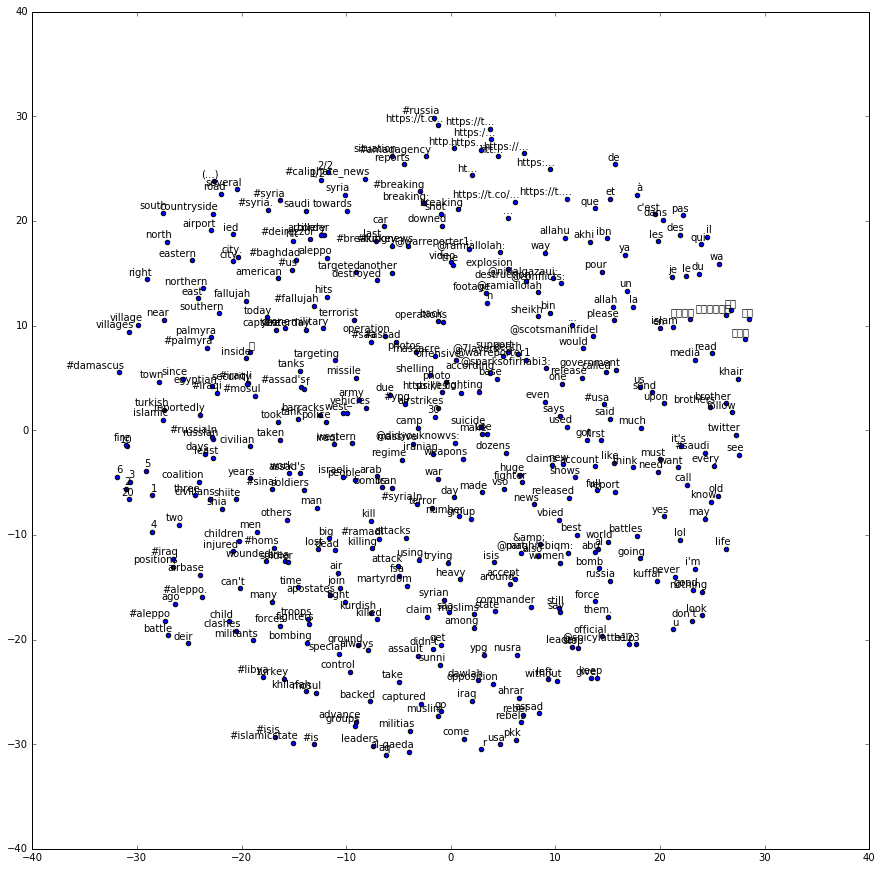

In [16]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)